## Sentiment Analysis for Whispr

1. import data from google sheets
2. clean dataset and create synthetic variables
3. summarize dataset: how many records per category, reviews over time
4. evaluate sentiment of review, give confidence interval
5. calculate summary insights: average sentiment / subjectivity per item, reviews per item
6. compare against manual evaluation
7. export data to google sheets

In [1]:
import pandas as pd
import numpy as np
import os
from textblob import TextBlob
import gspread
from datetime import datetime
from oauth2client.service_account import ServiceAccountCredentials
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.max_rows = 100

In [2]:
pwd

'/Users/christinejiang/Documents/Python/Sentiment_Analysis'

### 1. Import data from GS
- connect to google sheets API
- create spreadsheet and worksheet objects, explore GSpread library
- create dataframe of reviews

In [3]:
#1 define the scope of your access tokens
scope = ['https://www.googleapis.com/auth/drive','https://spreadsheets.google.com/feeds']

#2 after getting oauth2 credentials in a json, obtain an access token from google authorization server
#by creating serviceaccountcredentials and indicating scope, which controls resources / operations that an
#access token permits
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

#3 log into the google API using oauth2 credentials
#returns gspread.Client instance
c = gspread.authorize(creds)

In [4]:
#create spreadsheet instance
spreadsheet = c.open('UK Sentiment')

#create worksheet instance
worksheet = spreadsheet.worksheet('UK_Reviews')

#get list of dictionaries from worksheet contents
records = worksheet.get_all_records()

#create dataframe from this list of dictionaries
reviews = pd.DataFrame(records)
columns_to_keep = ['review_rating',
                  'review_datedate',
                  'review_headline',
                  'review_size_info',
                  'Review',
                  'Product (Taste/Experience)',
                  'Price']
clean_reviews = reviews[columns_to_keep]

In [5]:
clean_reviews.head(2)

,review_rating,review_datedate,review_headline,review_size_info,Review,Product (Taste/Experience),Price
0,5.0 out of 5 stars,2 November 2017,A very tasty and well-balanced treat,Flavour Name: Dark Chocolate Nuts and Sea Salt,"I really like these bars, and so do the other ...",1,
1,5.0 out of 5 stars,4 August 2019,Great size snack for those of us wanting a hea...,Flavour Name: Dark Chocolate Nuts and Sea Salt,I purchased these because I’m on the 16:8 IF d...,1,


### 2. Data preprocessing

In [8]:

#create numeric rating column
clean_reviews['rating'] = clean_reviews['review_rating'].apply(lambda x: int(x[0]))

#create timestamp from review date
clean_reviews['datestamp'] = clean_reviews['review_datedate'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))

#create shortened object name
clean_reviews['clean_headline'] = clean_reviews['review_size_info'].apply(lambda x: x.split(': ')[-1])

clean_reviews['Product (Taste/Experience)'] = clean_reviews['Product (Taste/Experience)'].replace({'':0}).astype('int8')

final_clean = clean_reviews[['rating','datestamp','clean_headline','review_headline','Review','Product (Taste/Experience)']]

#format columns
final_clean.rename(columns={'clean_headline':'Item_Name','Product (Taste/Experience)':'Product'}, inplace = True) 
final_clean.columns = map(str.capitalize,final_clean.columns)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [9]:
final_clean

,Rating,Datestamp,Item_name,Review_headline,Review,Product
0,5,2017-11-02,Dark Chocolate Nuts and Sea Salt,A very tasty and well-balanced treat,"I really like these bars, and so do the other ...",1
1,5,2019-08-04,Dark Chocolate Nuts and Sea Salt,Great size snack for those of us wanting a hea...,I purchased these because I’m on the 16:8 IF d...,1
2,5,2019-08-20,Dark Chocolate Nuts and Sea Salt,Price varies a lot !!!,These are great bars. I find when I'm training...,1
3,5,2019-09-07,Dark Chocolate Almond Mint,Possibly the best tasting healthiest snack bar...,Not a protein bar but a very health-designed s...,1
4,5,2019-05-09,Dark Chocolate Nuts and Sea Salt,Definitely a bar to try and enjoy,So good and actually quite low in sugar all co...,1
...,...,...,...,...,...,...
279,5,2019-12-09,Caramel Almond and Sea Salt,delicious,The price- a little too high.,0
280,5,2019-12-08,Dark Chocolate Nuts and Sea Salt,Healthy Snack,These are filling without too much sweetness. ...,1
281,5,2019-12-08,Maple Glazed Pecan & Sea Salt,Super,Super bars nice they are not chocolatey! Only ...,1
282,4,2019-12-09,Dark Chocolate Nuts and Sea Salt,A nutty bar as a nice alternative to a chocola...,This product is a tasty nut snack.,1


### 3. Exploratory Analysis
- histogram of ratings
- average / median / max / count of ratings per item type
- overlay ratings with count graph

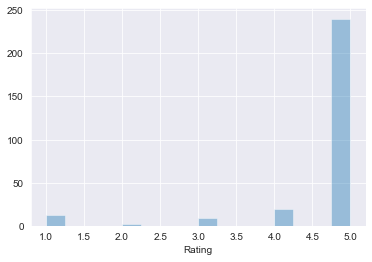

In [10]:
sns.set_style('darkgrid')
sns.distplot(final_clean['Rating'],kde = False)

In [11]:
final_clean['Rating'].value_counts().sort_index(ascending = False)

5    240
4     20
3      9
2      2
1     13
Name: Rating, dtype: int64

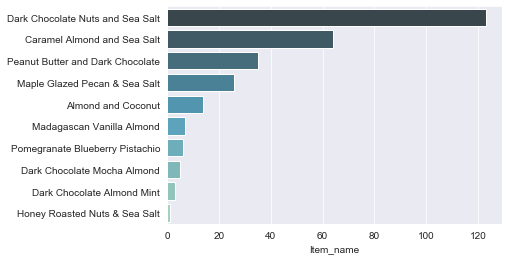

In [12]:
items = pd.DataFrame(final_clean['Item_name'].value_counts())
sns.barplot(items['Item_name'],items.index,palette = "GnBu_d")

In [13]:
final_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 6 columns):
Rating             284 non-null int64
Datestamp          284 non-null datetime64[ns]
Item_name          284 non-null object
Review_headline    284 non-null object
Review             284 non-null object
Product            284 non-null int8
dtypes: datetime64[ns](1), int64(1), int8(1), object(3)
memory usage: 11.5+ KB


In [14]:
summary = (final_clean.groupby('Item_name')['Rating','Product']
     .agg({'avg':np.mean,'median':np.median, 'min':np.min, 'count':len}))
    # .sort_values(by = ('count','Rating'), ascending = False))

summary

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


avg           median            min  \
                                    Rating   Product Rating Product Rating   
Item_name                                                                    
Almond and Coconut                4.785714  1.142857      5       1      2   
Caramel Almond and Sea Salt       4.859375  1.140625      5       1      3   
Dark Chocolate Almond Mint        5.000000  1.000000      5       1      5   
Dark Chocolate Mocha Almond       4.200000  1.600000      5       1      2   
Dark Chocolate Nuts and Sea Salt  4.544715  1.097561      5       1      1   
Honey Roasted Nuts & Sea Salt     5.000000  1.000000      5       1      5   
Madagascan Vanilla Almond         4.142857  1.285714      5       1      1   
Maple Glazed Pecan & Sea Salt     4.846154  1.038462      5       1      1   
Peanut Butter and Dark Chocolate  4.628571  1.171429      5       1      1   
Pomegranate Blueberry Pistachio   4.833333  1.500000      5       1      4   

                                          count          
                                 Product Rating Product  
Item_name                                                
Almond and Coconut                     0     14      14  
Caramel Almond and Sea Salt            0     64      64  
Dark Chocolate Almond Mint             1      3       3  
Dark Chocolate Mocha Almond            1      5       5  
Dark Chocolate Nuts and Sea Salt       0    123     123  
Honey Roasted Nuts & Sea Salt          1      1       1  
Madagascan Vanilla Almond              1      7       7  
Maple Glazed Pecan & Sea Salt          0     26      26  
Peanut Butter and Dark Chocolate       1     35      35  
Pomegranate Blueberry Pistachio        1      6       6

### 4. Text analysis
- Calculate polarity (pos vs. negative) and subjectivity (fact vs. opinion) for each review & review headline
- Calculate summary stats of results: average sentiment per category, over time, etc

In [15]:
pol = lambda x: TextBlob(x).polarity
final_clean['headline_pol'] = final_clean['Review_headline'].apply(pol)
final_clean['review_pol'] = final_clean['Review'].apply(pol)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
final_clean.head(2)

,Rating,Datestamp,Item_name,Review_headline,Review,Product,headline_pol,review_pol
0,5,2017-11-02,Dark Chocolate Nuts and Sea Salt,A very tasty and well-balanced treat,"I really like these bars, and so do the other ...",1,0.2000,0.266641
1,5,2019-08-04,Dark Chocolate Nuts and Sea Salt,Great size snack for those of us wanting a hea...,I purchased these because I’m on the 16:8 IF d...,1,0.7125,0.295278


### 5. Evaluate accuracy

In [17]:
(final_clean.groupby('Item_name')[['headline_pol','review_pol','Rating','Product']]
            .agg({'avg':np.mean,'median':np.median,'count':len}).sort_values(by = ('count','review_pol'),
                                                                            ascending = False))

avg                                 \
                                 headline_pol review_pol    Rating   Product   
Item_name                                                                      
Dark Chocolate Nuts and Sea Salt     0.415861   0.400751  4.544715  1.097561   
Caramel Almond and Sea Salt          0.387010   0.394393  4.859375  1.140625   
Peanut Butter and Dark Chocolate     0.276270   0.495556  4.628571  1.171429   
Maple Glazed Pecan & Sea Salt        0.395769   0.508816  4.846154  1.038462   
Almond and Coconut                   0.210714   0.474734  4.785714  1.142857   
Madagascan Vanilla Almond            0.333333   0.458876  4.142857  1.285714   
Pomegranate Blueberry Pistachio      0.158333   0.221875  4.833333  1.500000   
Dark Chocolate Mocha Almond          0.056250   0.360083  4.200000  1.600000   
Dark Chocolate Almond Mint           0.166667   0.244669  5.000000  1.000000   
Honey Roasted Nuts & Sea Salt        0.750000  -0.291667  5.000000  1.000000   

                                       median                            \
                                 headline_pol review_pol Rating Product   
Item_name                                                                 
Dark Chocolate Nuts and Sea Salt     0.450000   0.412500      5       1   
Caramel Almond and Sea Salt          0.218056   0.406250      5       1   
Peanut Butter and Dark Chocolate     0.000000   0.500000      5       1   
Maple Glazed Pecan & Sea Salt        0.458333   0.550000      5       1   
Almond and Coconut                   0.000000   0.402222      5       1   
Madagascan Vanilla Almond            0.233333   0.487500      5       1   
Pomegranate Blueberry Pistachio      0.000000   0.115625      5       1   
Dark Chocolate Mocha Almond          0.000000   0.275000      5       1   
Dark Chocolate Almond Mint           0.000000   0.192861      5       1   
Honey Roasted Nuts & Sea Salt        0.750000  -0.291667      5       1   

                                        count                            
                                 headline_pol review_pol Rating Product  
Item_name                                                                
Dark Chocolate Nuts and Sea Salt        123.0      123.0    123     123  
Caramel Almond and Sea Salt              64.0       64.0     64      64  
Peanut Butter and Dark Chocolate         35.0       35.0     35      35  
Maple Glazed Pecan & Sea Salt            26.0       26.0     26      26  
Almond and Coconut                       14.0       14.0     14      14  
Madagascan Vanilla Almond                 7.0        7.0      7       7  
Pomegranate Blueberry Pistachio           6.0        6.0      6       6  
Dark Chocolate Mocha Almond               5.0        5.0      5       5  
Dark Chocolate Almond Mint                3.0        3.0      3       3  
Honey Roasted Nuts & Sea Salt             1.0        1.0      1       1

In [337]:
#correct - cases where rating < 3 and polarity is negative
final_clean[(final_clean['Rating']<4) & (final_clean['headline_pol']<0)]

#corret - cases where rating > 4 and polarity is positive
#incorrect - cases where rating < 3 and polarity is positive
#incrrect - cases where rating > 4 and polarity is negative


,Rating,Datestamp,Item_name,Review_headline,Review,Product,headline_pol,review_pol
22,1,2019-11-07,Dark Chocolate Nuts and Sea Salt,The bars were very hard and not fresh,Kind bars are usually delicious. I was happy I...,1,-0.264583,0.320139
54,1,2019-05-24,Dark Chocolate Nuts and Sea Salt,Extremely disappointed,"No expiry date on the box,No expiry date on th...",0,-0.750000,0.000000
97,2,2019-02-03,Dark Chocolate Mocha Almond,very hard to bite on,The bars are really hard to bite and chew. Tas...,3,-0.379167,0.125000
166,1,2019-08-06,Dark Chocolate Nuts and Sea Salt,This is an unhealthy snack,Way too much salt,3,-0.400000,0.200000
251,1,2017-08-31,Madagascan Vanilla Almond,"DO NOT WASTE YOUR MONEY on this poor quality, ...",I spent £30 on 2 boxes of these bars for my da...,3,-0.150000,0.132143
255,1,2018-10-06,Dark Chocolate Nuts and Sea Salt,"Very unbalanced, almost no chocolate, hard to eat",Ive tried some good chocolates with salt so i ...,3,-0.045833,-0.065833


In [341]:
#create positive or negative flag
def pos_or_neg(polarity):
    if polarity > 0:
        return 'positive'
    if polarity < 0:
        return 'negative'
    return 'neutral'
        
final_clean['headline_posneg'] = final_clean['headline_pol'].apply(pos_or_neg)
final_clean['review_posneg'] = final_clean['review_pol'].apply(pos_or_neg)

#create polarity match flag
def match(row):
    if row['headline_pol'] == row['review_pol']:
        return True
    return False

final_clean['match'] = final_clean.apply(match, axis = 1)

#create accuracy flag
def correct(x, polarity_col):
    if x['Rating'] > 3 and x[polarity_col] > 0:
        return True
    if x['Rating'] == 3 and x[polarity_col] == 0:
        return True
    if x['Rating'] < 3 and x[polarity_col] < 0:
        return True
    return False

final_clean['headline_correct'] = final_clean.apply((lambda x: correct(x,'headline_pol')),axis=1)

In [342]:
final_clean.head()

,Rating,Datestamp,Item_name,Review_headline,Review,Product,headline_pol,review_pol,headline_posneg,review_posneg,match,headline_correct
0,5,2017-11-02,Dark Chocolate Nuts and Sea Salt,A very tasty and well-balanced treat,"I really like these bars, and so do the other ...",1,0.2000,0.266641,positive,positive,False,True
1,5,2019-08-04,Dark Chocolate Nuts and Sea Salt,Great size snack for those of us wanting a hea...,I purchased these because I’m on the 16:8 IF d...,1,0.7125,0.295278,positive,positive,False,True
2,5,2019-08-20,Dark Chocolate Nuts and Sea Salt,Price varies a lot !!!,These are great bars. I find when I'm training...,1,0.0000,0.298889,neutral,positive,False,False
3,5,2019-09-07,Dark Chocolate Almond Mint,Possibly the best tasting healthiest snack bar...,Not a protein bar but a very health-designed s...,1,0.5000,0.192861,positive,positive,False,True
4,5,2019-05-09,Dark Chocolate Nuts and Sea Salt,Definitely a bar to try and enjoy,So good and actually quite low in sugar all co...,1,0.2000,0.400000,positive,positive,False,True


In [306]:
final_clean['headline_correct'].value_counts()

True     164
False    120
Name: headline_correct, dtype: int64

In [217]:
(final_clean.groupby(['Rating','headline_posneg','review_posneg'])['review_pol','headline_pol']
 .agg({'avg':np.mean,'median':np.median,'count':len}))


avg                  median  \
                                     review_pol headline_pol review_pol   
Rating headline_posneg review_posneg                                      
1      negative        negative       -0.065833    -0.045833  -0.065833   
                       neutral         0.000000    -0.750000   0.000000   
                       positive        0.217427    -0.271528   0.200000   
       neutral         negative       -0.111328     0.000000  -0.111328   
                       neutral         0.000000     0.000000   0.000000   
                       positive        0.271528     0.000000   0.114583   
       positive        positive        0.068775     0.575000   0.068775   
2      negative        positive        0.125000    -0.379167   0.125000   
       neutral         positive        0.141667     0.000000   0.141667   
3      neutral         positive        0.008333     0.000000   0.008333   
       positive        positive        0.344575     0.293125   0.284220   
4      negative        negative       -0.262500    -0.600000  -0.262500   
       neutral         neutral         0.000000     0.000000   0.000000   
                       positive        0.433333     0.000000   0.500000   
       positive        negative       -0.068750     0.750000  -0.068750   
                       neutral         0.000000     0.383333   0.000000   
                       positive        0.289530     0.544059   0.200000   
5      negative        positive        0.437500    -0.120000   0.437500   
       neutral         negative       -0.218229     0.000000  -0.017187   
                       neutral         0.000000     0.000000   0.000000   
                       positive        0.532336     0.000000   0.500000   
       positive        negative       -0.100521     0.737500  -0.048542   
                       neutral         0.000000     0.633333   0.000000   
                       positive        0.501432     0.667551   0.500000   

                                                       count               
                                     headline_pol review_pol headline_pol  
Rating headline_posneg review_posneg                                       
1      negative        negative         -0.045833        1.0          1.0  
                       neutral          -0.750000        1.0          1.0  
                       positive         -0.264583        3.0          3.0  
       neutral         negative          0.000000        2.0          2.0  
                       neutral           0.000000        1.0          1.0  
                       positive          0.000000        3.0          3.0  
       positive        positive          0.575000        2.0          2.0  
2      negative        positive         -0.379167        1.0          1.0  
       neutral         positive          0.000000        1.0          1.0  
3      neutral         positive          0.000000        1.0          1.0  
       positive        positive          0.216667        8.0          8.0  
4      negative        negative         -0.600000        1.0          1.0  
       neutral         neutral           0.000000        1.0          1.0  
                       positive          0.000000        4.0          4.0  
       positive        negative          0.750000        2.0          2.0  
                       neutral           0.350000        3.0          3.0  
                       positive          0.416667        9.0          9.0  
5      negative        positive         -0.120000        2.0          2.0  
       neutral         negative          0.000000        3.0          3.0  
                       neutral           0.000000        7.0          7.0  
                       positive          0.000000       85.0         85.0  
       positive        negative          0.875000        4.0          4.0  
                       neutral           0.700000        9.0          9.0  
                       positive          0

In [297]:
(final_clean.groupby(['headline_posneg','review_posneg'])['review_pol','headline_pol']
 .agg({'avg':np.mean,'median':np.median,'count':len}))


avg                  median               \
                              review_pol headline_pol review_pol headline_pol   
headline_posneg review_posneg                                                   
negative        negative       -0.164167    -0.322917  -0.164167    -0.322917   
                neutral         0.000000    -0.750000   0.000000    -0.750000   
                positive        0.275380    -0.238958   0.237500    -0.219792   
neutral         negative       -0.175469     0.000000  -0.068750     0.000000   
                neutral         0.000000     0.000000   0.000000     0.000000   
                positive        0.510069     0.000000   0.500000     0.000000   
positive        negative       -0.089931     0.741667  -0.060417     0.775000   
                neutral         0.000000     0.570833   0.000000     0.600000   
                positive        0.474403     0.638746   0.475000     0.700000   

                                   count               
                              review_pol headline_pol  
headline_posneg review_posneg                          
negative        negative             2.0          2.0  
                neutral              1.0          1.0  
                positive             6.0          6.0  
neutral         negative             5.0          5.0  
                neutral              9.0          9.0  
                positive            94.0         94.0  
positive        negative             6.0          6.0  
                neutral             12.0         12.0  
                positive           149.0        149.0

### Exploring NLTK

In [13]:
from nltk import tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import stem
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

In [468]:
final_clean['Review'][0]
test = final_clean['Review'][0]

sentences = sent_tokenize(test)
words = word_tokenize(test)
fdist = FreqDist(test)

In [16]:
sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
punctuations="?:!.,;"
sentence_words = nltk.word_tokenize(sentence)
# for word in sentence_words:
#     if word in punctuations:
#         sentence_words.remove(word)

In [17]:
sentence_words

['He',
 'was',
 'running',
 'and',
 'eating',
 'at',
 'same',
 'time',
 '.',
 'He',
 'has',
 'bad',
 'habit',
 'of',
 'swimming',
 'after',
 'playing',
 'long',
 'hours',
 'in',
 'the',
 'Sun',
 '.']

In [11]:
porter = stem.PorterStemmer()
lancaster = stem.LancasterStemmer()
word_list = ["friend", "friendship", "friends", "friendships","stabil","destabilize","misunderstanding","railroad","moonlight","football"]
print("{0:20}{1:20}{2:20}".format("Word","Porter Stemmer","lancaster Stemmer"))
for word in word_list:
    print("{0:20}{1:20}{2:20}".format(word,porter.stem(word),lancaster.stem(word)))


Word                Porter Stemmer      lancaster Stemmer   
friend              friend              friend              
friendship          friendship          friend              
friends             friend              friend              
friendships         friendship          friend              
stabil              stabil              stabl               
destabilize         destabil            dest                
misunderstanding    misunderstand       misunderstand       
railroad            railroad            railroad            
moonlight           moonlight           moonlight           
football            footbal             footbal             


In [490]:
stop_words = (stopwords.words("english"))

In [514]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [515]:
important_words = []
for word in words:
    if word not in stop_words:
        important_words.append(word)

ps = WordNetLemmatizer()
stemmed_words = []
for word in important_words:
    stemmed_words.append(ps.lemmatize(word))

In [516]:
print(important_words)
print(stemmed_words)

['I', 'really', 'like', 'bars', ',', 'members', 'family', '.', 'It', "'s", 'slight', 'saltiness', 'dark', 'chocolate', 'work', 'well', 'together', 'nuts.As', 'sweet', 'snacks', 'go', ',', 'I', "'d", 'consider', 'reasonably', 'healthy', 'moderation', ',', 'balance', 'nutrients', ':', '37', '%', 'fat', '(', 'mostly', 'good', 'fats', ')', ',', '40', '%', 'carbs', '(', '14', '%', 'sugar', ')', ',', '18', '%', 'fibre', '14', '%', 'protein', '.', 'It', "'s", 'dairy', 'free', 'gluten', 'free', ',', 'high', 'content', 'nuts', ',', 'contains', 'good', 'micronutrients', 'well.Overall', ',', 'want', 'filling', 'treat', ',', "'s", 'pretty', 'tasty', 'well-balanced', 'opinion', '.']
['I', 'really', 'like', 'bar', ',', 'member', 'family', '.', 'It', "'s", 'slight', 'saltiness', 'dark', 'chocolate', 'work', 'well', 'together', 'nuts.As', 'sweet', 'snack', 'go', ',', 'I', "'d", 'consider', 'reasonably', 'healthy', 'moderation', ',', 'balance', 'nutrient', ':', '37', '%', 'fat', '(', 'mostly', 'good', 

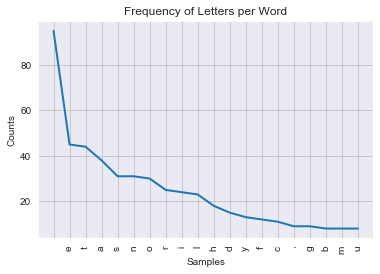

In [484]:
fdist.plot(20, cumulative = False, title = 'Frequency of Letters per Word')

In [ ]:
#graph the most commonly used words that are not stop words in the reviews?